# Implement Yoshua Bengio's Paper - 'A Neural Probabilistic Language Model' (2003)

Link for the paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

Bigram Language Model file can be found here: https://github.com/GauravAtavale/Large-Language-Model-in-7-days


#### **Why this paper?**

There are 3 main reasons why this paper is considered a landmark in the development of language models:

> **`1.Paradigm Shift`**: Moved NLP from brittle, count-based methods (N-gram) to flexible, learnable representations, unlocking semantic understanding..

> **`2.Foundation for Modern NLP`**: Embeddings and neural architectures it pioneered are core to GPT, BERT, and beyond.

> **`3.Word Embeddings `** : Ideas proposed in the paper about learning the embeddings based on the context is still the state of the art approach and has directly influenced in developing sophisticated embeddings like Word2Vec (2013).

#### **What are we going to cover?**

```
We will implement the following 2 tasks:
Task 1: Name Generation using the next charachter prediction
Task 2: Words Generation using the next charachter prediction
```

#### **Summary of the Proposed Architecture:**

> ##### Biggest drawback of N-gram models is that it suffered from sparsity and exponential growth in parameters as context size increased. This Neural network based approach solved it.

> ##### The architecture proposed has 3 layers with learnable parameters
*   1. Embedding layer - The embeddings are initiated randomly and are learned in training
*   2. Hidden layer
*   3. Output layer

> ##### Tanh is the activation used

> ##### Context length used is 3 (how many tokens are used to predict next token). But this can easily be extedned to higher length

> ##### It is an extremely flexible Neural network architecture - The number of dimensions used for embeddings and number of hidden layers can be extended to achieve better performance  

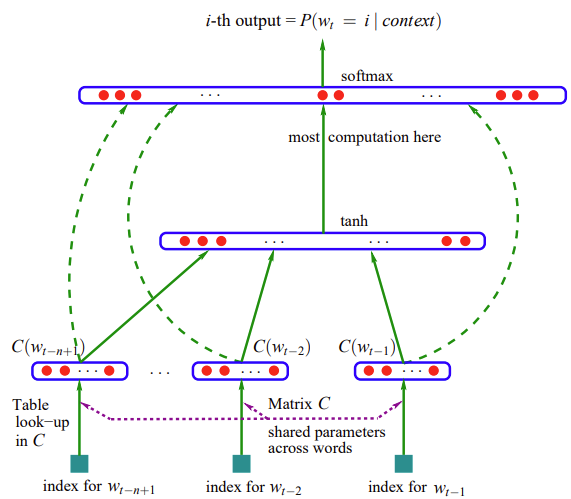

# Generate Names using the Neural Network approach of predicting the next token

**Vocabulary** - This is a character level model. So 26 alphabets  + start/end token is the vovabulary

**Token** - Charachters

In [1]:
# Import relevant libraries
from google.colab import drive
import requests
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
# drive.mount('/content/drive') # The file can be uploaded to drive. Don't forget to mount drive in that case

In [2]:
# The file is in the Git repo: https://github.com/GauravAtavale/Large-Language-Model-in-7-days

# This file has a list of 32033 names collected. This dataset will be used to generate new names.
git_url = "https://raw.githubusercontent.com/GauravAtavale/Large-Language-Model-in-7-days/refs/heads/main/names.txt"
response = requests.get(git_url)
response.raise_for_status()
words = response.text.splitlines()

#words = open('names.txt','r').read().splitlines() # if the file is local
print(f"Data type of words: {type(words)} \nNumber of names in file: {len(words)}")

Data type of words: <class 'list'> 
Number of names in file: 32033


In [3]:
# Looking at the first 10 names in the file
# Note: this dataset is a cleaned dataset with only alphbets(lowercase) in it. No need to clean further
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
# First let's check Unique characters in the data
chars = sorted(list(set(''.join(words))))
print("Unique Charachters:", chars)
print("Number of unique Chars:", len(chars))

Unique Charachters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Number of unique Chars: 26


In [5]:
# Note: 'chars' is sorted list of unique characters and index starts from 1....26
string_to_ind = {s:i+1 for i,s in enumerate(chars)} # +1 is to offset so that a starts with index 1

# We can introduce tokens <'S'> and <'E'>. But since we will have <'S'> as the first char(rows) and <'E'> as second (columns)
# it would be convinient to replace them with '.', depicting start and end when represented in row or col respectively
string_to_ind['.'] = 0

print(dict(list(string_to_ind.items())[0:5]))
print(dict(list(string_to_ind.items())[22:]))

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5}
{'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [6]:
# Get reverse of string_to_ind for labelling later
ind_to_string = {i:s for s,i in string_to_ind.items()}

## Illustration with 2 examples

The architecture in Bengio's paper looks at prior 3 tokens to predict the next token. This implies the context length of the model is 3.


The beginning of the series is represented as **`'...'`** here



In [7]:
context_len = 3 # As per the architecture which can be extended
X_list = []
Y_list = []

for w in words[0:2]: # First 2 names are considered for the example
  print("Name:",w)
  # Initially the context window is '...' to predict the first token. The token '.' has index 0
  context_block = [0] * context_len
  for ch in w + '.':
    # Create X and Y based on the context and the next token
    X_list.append(context_block) # Append the index of context_block
    Y_list.append(string_to_ind[ch]) # Corresponding index of next token
    print(''.join(ind_to_string[i] for i in context_block),"------next-token------>",ch)
    context_block = context_block[1:] + [string_to_ind[ch]]
  print("------------------------------------")
print("Created X data and corresponding Y values:", X_list[0], "---->",Y_list[0],"\nRemaining data: ")

print(X_list[1:])
print(Y_list[1:])

Name: emma
... ------next-token------> e
..e ------next-token------> m
.em ------next-token------> m
emm ------next-token------> a
mma ------next-token------> .
------------------------------------
Name: olivia
... ------next-token------> o
..o ------next-token------> l
.ol ------next-token------> i
oli ------next-token------> v
liv ------next-token------> i
ivi ------next-token------> a
via ------next-token------> .
------------------------------------
Created X data and corresponding Y values: [0, 0, 0] ----> 5 
Remaining data: 
[[0, 0, 5], [0, 5, 13], [5, 13, 13], [13, 13, 1], [0, 0, 0], [0, 0, 15], [0, 15, 12], [15, 12, 9], [12, 9, 22], [9, 22, 9], [22, 9, 1]]
[13, 13, 1, 0, 15, 12, 9, 22, 9, 1, 0]


In [8]:
# Create the final data
context_len = 3
X_list = []
Y_list = []

for w in words:
  context_block = [0] * context_len
  for ch in w + '.':
    X_list.append(context_block)
    Y_list.append(string_to_ind[ch])
    context_block = context_block[1:] + [string_to_ind[ch]]
X = torch.tensor(X_list)
Y = torch.tensor(Y_list)

In [9]:
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

## Initialize the embeddings

> Bengio's paper was one of the first papers to introduce learning embeddings based on the context

> Embeddings are randomly generated initially and are learned through training the Neural Network

> Number of dimensions of embeddings has to be decided... that tells how much information is wrapped in them

In [10]:
# Generating the embeddings
emb_dim = 2
vocab_len = len(string_to_ind)
print(f"Vocab length: {vocab_len}\nEmbedding dimension: {emb_dim}")

C = torch.randn((vocab_len,emb_dim)) # This is the initial embedding - Randomly generated

Vocab length: 27
Embedding dimension: 2


In [11]:
# Tensor C is the embeddings of the 27 characters we have in the vocabulary
print("Showing the first 5 tokens and their corresponding embeddings\n")
for i in range(5):print(f"Tokens: '{ind_to_string[i]}'    |    Embedding: {C[i]}")

Showing the first 5 tokens and their corresponding embeddings

Tokens: '.'    |    Embedding: tensor([0.2287, 0.7128])
Tokens: 'a'    |    Embedding: tensor([ 0.7195, -2.3990])
Tokens: 'b'    |    Embedding: tensor([0.0556, 0.9636])
Tokens: 'c'    |    Embedding: tensor([-1.7431, -1.1074])
Tokens: 'd'    |    Embedding: tensor([-0.9167, -0.6111])


## Visualize Embeddings before Learning

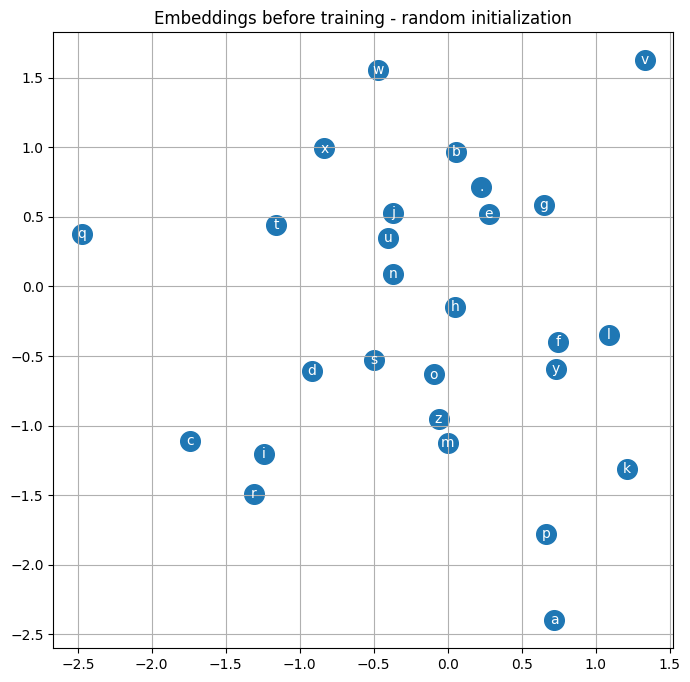

In [12]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), ind_to_string[i], ha="center", va="center", color="white")
plt.grid('minor')
plt.title("Embeddings before training - random initialization")
plt.show()

> Truly random distribution of embeddings => No learning

## Importance of uisng View to reshape

> #### The input data X has context length of 3 tokens (it looks into 3 prior tokens to predict next). And Embeddings has dimension = 2.
> #### This implies that each example in input data should be a vector of length 3 * 2 = 6 (context_len X embedding_dim)
> #### This is achieved easily using the View method in torch - which reshapes the data in desired dims





In [13]:
print("The first row in X is :", X[0])
print("\nThe corresponding embedding vector is :\n", C[X[0]], "\nand has a shape:", C[X[0]].shape)
print("\nThis has to be transformed into a vector of 1*6 and the best way is uing the 'view' function which reshapes the tensors:\n",C[X[0]].view(1,-1))
print("\nAs an example embeddings for the first 4 examples would look like this:\n",C[X[0:4]].view(X[0:4].shape[0],6))

The first row in X is : tensor([0, 0, 0])

The corresponding embedding vector is :
 tensor([[0.2287, 0.7128],
        [0.2287, 0.7128],
        [0.2287, 0.7128]]) 
and has a shape: torch.Size([3, 2])

This has to be transformed into a vector of 1*6 and the best way is uing the 'view' function which reshapes the tensors:
 tensor([[0.2287, 0.7128, 0.2287, 0.7128, 0.2287, 0.7128]])

As an example embeddings for the first 4 examples would look like this:
 tensor([[ 0.2287,  0.7128,  0.2287,  0.7128,  0.2287,  0.7128],
        [ 0.2287,  0.7128,  0.2287,  0.7128,  0.2787,  0.5236],
        [ 0.2287,  0.7128,  0.2787,  0.5236,  0.0020, -1.1246],
        [ 0.2787,  0.5236,  0.0020, -1.1246,  0.0020, -1.1246]])


In [14]:
# Getting the embeddings for all the examples in X dataset
vector_len = context_len * emb_dim

embedded_X = C[X].view(X.shape[0],vector_len)
print("Shape of X         :", X.shape)
print("Shape of embedded_X:", embedded_X.shape)

Shape of X         : torch.Size([228146, 3])
Shape of embedded_X: torch.Size([228146, 6])


## Start of Building the Neural Network


> The embeddings **`C`** is a parameter

> According to the architecture this is a simple Neural network with  1 hidden layer
`



In [15]:
# Lets build the first layer (the only layer)
n_hidden = 100
# emb_dim = 2 # Already defined above
# context_len = 3 # Already defined above
# input_dim = emb_dim * context_len
vector_len = context_len * emb_dim

w1 = torch.randn((embedded_X.shape[1],n_hidden)) # input vector_len = Context_len*emb_dim here it is 6
b1 = torch.randn(n_hidden)

print("Input data dimensions:", embedded_X.shape)
print("w1 dimensions:", w1.shape)
print("b1 dimensions:", b1.shape)

Input data dimensions: torch.Size([228146, 6])
w1 dimensions: torch.Size([6, 100])
b1 dimensions: torch.Size([100])


In [16]:
# Make sure the bias is broadcasted perfectly before proceeding
# Following Yoshua Bengio's paper tanh is used as the activation function
h = torch.tanh((embedded_X @ w1) + b1)
h .shape

torch.Size([228146, 100])

In [17]:
# Output layer
w2 = torch.randn((n_hidden,vocab_len))
b2 = torch.randn(vocab_len)
print("w2 dimensions:", w2.shape)
print("b2 dimensions:", b2.shape)

w2 dimensions: torch.Size([100, 27])
b2 dimensions: torch.Size([27])


In [18]:
# logits
logits = h @ w2 + b2
logits.shape

torch.Size([228146, 27])

In [19]:
# Get Manual softmax
# cts = logits.exp()
# probs = cts/cts.sum(1, keepdim = True)

# Softmax using torch method
y_pred = torch.softmax(logits,dim=1)
y_pred.shape

torch.Size([228146, 27])

In [20]:
# Looking at the result of a an example - For row 3, Predicted index = 24 but Actual value is Index 1 but
print("Looking at the softmax output of a an example (3 in this case):\n",y_pred[3])
print("\nPredicted index:",torch.argmax(y_pred[3]))
print("\nActual value:",Y[3])

Looking at the softmax output of a an example (3 in this case):
 tensor([6.9734e-09, 2.4028e-07, 1.5292e-10, 5.5321e-04, 8.4480e-08, 3.6406e-03,
        9.9580e-01, 2.9202e-09, 2.0948e-06, 3.5816e-13, 2.9698e-08, 1.9272e-07,
        2.5952e-08, 2.6209e-10, 4.8926e-10, 5.0133e-10, 5.1534e-11, 2.6533e-06,
        3.1409e-07, 3.2579e-13, 1.4195e-08, 2.6653e-09, 5.6951e-10, 1.2571e-12,
        1.2021e-08, 3.7816e-07, 1.2455e-13])

Predicted index: tensor(6)

Actual value: tensor(1)


In [21]:
# Log loss or Crossentropy loss is used here
loss = -y_pred[torch.arange(Y.shape[0]),Y].log().mean()
loss

tensor(18.4542)

## Get mini batches - for efficient training

In [22]:
def get_batch_indices(data, batch_size):
  """ Takes in input data and gives out the indices of mini batches
      input: Input data and desired Batch size
      output: List of indices of mini batches
  """
  torch.manual_seed(42)
  num_samples = data.shape[0] # 228146 for all of X train data
  indices = torch.randperm(num_samples) # Shuffle indices between 0 - 228146
  mini_batches_indices = []
  num_batches = (num_samples + batch_size - 1) // batch_size  # Ceiling division

  mini_batches_indices = []
  for i in range(num_batches):
      start_idx = i * batch_size
      end_idx = start_idx + batch_size
      batch_indices = indices[start_idx:end_idx]
      mini_batches_indices.append(batch_indices)
  return mini_batches_indices

In [23]:
# As an example
mini_batch_check = get_batch_indices(X, batch_size=100)
print("Examples in training data:", X.shape[0],"\nNumber of mini Batches:",  len(mini_batch_check))

Examples in training data: 228146 
Number of mini Batches: 2282


## Putting all this together -  so far

In [24]:
# Initiate all relevant parameters
context_len = 3
emb_dim = 2
n_hidden = 100
batch_size = 10000

vocab_len = len(string_to_ind)
data_vector_len = context_len * emb_dim
g = torch.Generator().manual_seed(2147483647) # For reproducibility

# Embedding initialization -  A parameter
C = torch.randn((vocab_len,emb_dim), generator=g)

# Initialize the first layer (the only layer)
w1 = torch.randn((data_vector_len,n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)

# Initialize the Output layer
w2 = torch.randn((n_hidden,vocab_len), generator=g)
b2 = torch.randn(vocab_len, generator=g)

# The learnable parameters in this Architecture
parameters = [C,w1,b1,w2,b2]
for p in parameters:
  p.requires_grad = True # Make sure the 'requires_grad' is True, which will help us calculate the gradients in the loss.backward() step

print("Number of parameters learned in this Network:",sum(p.nelement() for p in parameters))

Number of parameters learned in this Network: 3481


In [25]:
# Mini Batch update

mini_batch_ind = get_batch_indices(X, batch_size)
loss_track_global = []
num_epochs = 500

for epoch in range(num_epochs):
  loss_track_local = []
  for idx in mini_batch_ind:
  # Forward pass
  # emb = C[X[idx]] # Get the corresponding embeddings for the X data
    embedded_X = C[X[idx]].view(X[idx].shape[0],vector_len) # Get the corresponding embeddings for the X data
    h = torch.tanh((embedded_X @ w1) + b1) # Calculate hidden layer values
    logits = h @ w2 + b2 # op layer logits
    #The above loss computation can be replicated with the below efficient code -- this is better for forward pass, backward pass --> efficient numerical computations
    loss = F.cross_entropy(logits, Y[idx])
    # if epoch % 100 == 0:
    #   print(loss.item())
    # print(loss.item())

    # Backward pass
    for p in parameters:
      p.grad = None
    loss.backward()
      # Get stats
    loss_track_local.append(loss.item())
    #update
    for p in parameters:
      p.data += -0.01 * p.grad
  avg_loss = sum(loss_track_local)/len(mini_batch_ind)
  loss_track_global.append(avg_loss)
  if epoch % 100 == 0 or epoch == num_epochs-1:
    print(f"Average loss after {epoch} is: {sum(loss_track_local)/len(mini_batch_ind) :.2f}")

Average loss after 0 is: 17.20
Average loss after 100 is: 2.89
Average loss after 200 is: 2.68
Average loss after 300 is: 2.60
Average loss after 400 is: 2.57
Average loss after 499 is: 2.55


In [26]:
embedded_X = C[X].view(X.shape[0],vector_len) # Get the corresponding embeddings for the X data
h = torch.tanh((embedded_X @ w1) + b1) # Calculate hidden layer values
logits = h @ w2 + b2 # op layer logits
loss = F.cross_entropy(logits, Y)
print(f"Loss on all of the data {loss.item():.4f}")

Loss on all of the data 2.5473


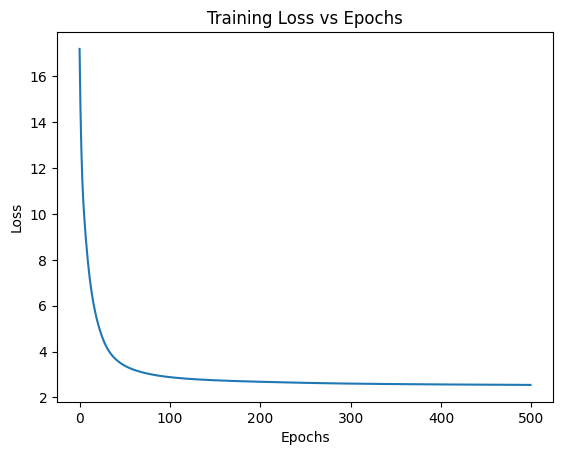

In [27]:
plt.plot(range(num_epochs), loss_track_global)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Epochs")
plt.show()

## Visualize Embeddings - Intermediate

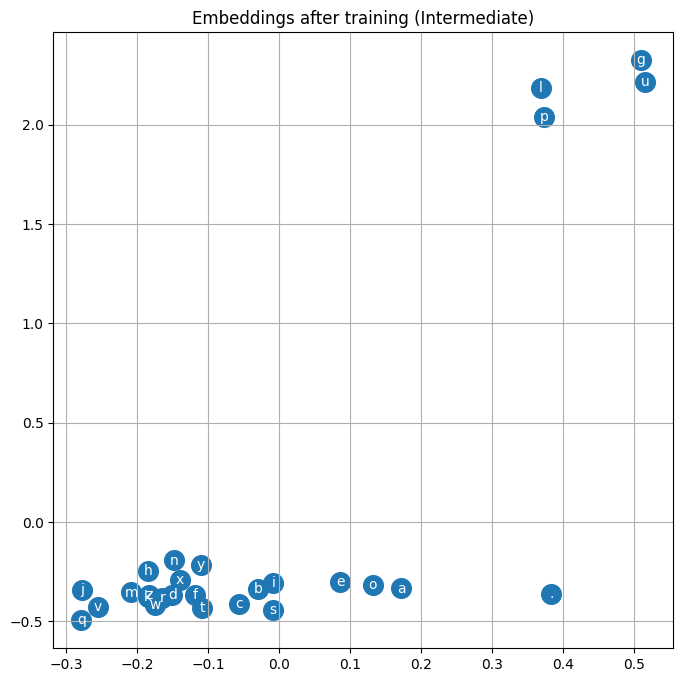

In [28]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), ind_to_string[i], ha="center", va="center", color="white")
plt.grid('minor')
plt.title("Embeddings after training (Intermediate)")
plt.show()

Some learning has happened based on the visuals above where it is segregating alphabets based on usage. But still lot can be improved

# Improving Efficiency of the code

#### A few things can be done to ensure better performance and efficiency of the model

#### Following are implemented to improve the model performance and efficiency

```
1. Split Train, Test, and Validation set
2. Use Kaimming initialization to initialize weights
3. Optimize Learning rates
4. Batch Normalization
```


## 1. Split data into Train, Dev, Test split

In [29]:
# Shuffle X
idx = torch.randperm(X.shape[0])
X = X[idx]
Y = Y[idx]

n1 = int(len(X)*0.8) # 80% Training
n2 = int(len(X)*0.9) # 10% Validation and 10% Test data

X_train, Y_train = X[0:n1], Y[0:n1]
X_val, Y_val = X[n1:n2], Y[n1:n2]
X_test, Y_test = X[n2:], Y[n2:]

print("Train data:", X_train.shape, Y_train.shape, "      | ", round(X_train.shape[0]/X.shape[0],2)*100, "% of X")
print("Validation data:", X_val.shape, Y_val.shape, "   | ", round(X_val.shape[0]/X.shape[0],2)*100, "% of X")
print("Test data:", X_test.shape, Y_test.shape, "         | ", round(X_test.shape[0]/X.shape[0],2)*100, "% of X")

Train data: torch.Size([182516, 3]) torch.Size([182516])       |  80.0 % of X
Validation data: torch.Size([22815, 3]) torch.Size([22815])    |  10.0 % of X
Test data: torch.Size([22815, 3]) torch.Size([22815])          |  10.0 % of X


## 2. Determine Learning rate and run only on sample batches

> Idea is to quickly run a bunch of epochs with different learning rates and determine where is the best loss we achieve

> Learning rates are between 0 and 1. So inorder to explore this, we need to explore in exponential scale rather than Linear scale. This enables us to explore extensively in the range 0-0.1 where we generally find the best LR

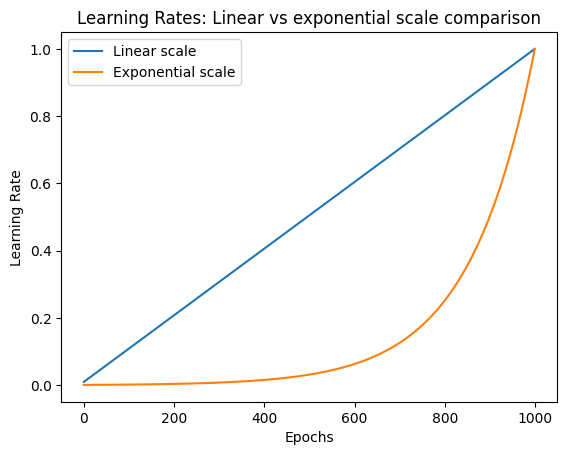

In [30]:
# LR Exploration - Scale comparison
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

ints = torch.arange(1000)
# print(ints)
plt.plot(ints,torch.linspace(0.01,1,1000))
plt.plot(ints,lrs)
plt.legend(["Linear scale", "Exponential scale"])
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("Learning Rates: Linear vs exponential scale comparison")
plt.show()

In [31]:
g = torch.Generator().manual_seed(2147483647) # For reproducibility
C_temp = torch.randn((vocab_len,emb_dim), generator=g)
w1_temp = torch.nn.init.kaiming_normal_(torch.randn((data_vector_len,n_hidden), generator = g),nonlinearity='tanh',mode='fan_out')
b1_temp = torch.randn(n_hidden, generator=g)
w2_temp = torch.randn((n_hidden,vocab_len), generator=g)*0.01
b2_temp = torch.randn(vocab_len, generator=g)
parameters_temp = [C_temp,w1_temp,b1_temp,w2_temp,b2_temp]
for p_temp in parameters_temp:
  p_temp.requires_grad = True

num_epochs = 1000
loss_track = []
lowest_loss = np.inf
lowest_loss_epoch = 0

for epoch in range(num_epochs):
  ix = torch.randint(0,X.shape[0],(32,), generator=g)
  embedded_X = C_temp[X[ix]].view(X[ix].shape[0],data_vector_len)
  h = torch.tanh((embedded_X @ w1_temp) + b1_temp)
  logits = h @ w2_temp + b2_temp
  loss = F.cross_entropy(logits, Y[ix])
  if epoch % 100 == 0 or epoch == num_epochs-1:
    print(f"Sub sample loss at {epoch}: {loss.item() :.2f}")

  # Get stats
  loss_track.append(loss.item())
  if loss.item() < lowest_loss:
    lowest_loss = loss.item()
    lowest_loss_epoch = epoch

  # Backward pass
  for p_temp in parameters_temp:
    p_temp.grad = None
  loss.backward()

  # update
  lr = lrs[epoch].item()
  for p_temp in parameters_temp:
    p_temp.data += -lr * p_temp.grad

Sub sample loss at 0: 3.51
Sub sample loss at 100: 3.54
Sub sample loss at 200: 3.39
Sub sample loss at 300: 3.05
Sub sample loss at 400: 2.42
Sub sample loss at 500: 2.98
Sub sample loss at 600: 2.70
Sub sample loss at 700: 2.79
Sub sample loss at 800: 2.56
Sub sample loss at 900: 3.27
Sub sample loss at 999: 4.24


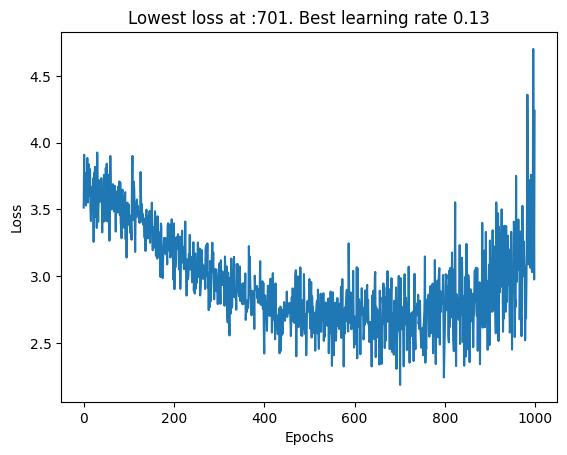

In [32]:
plt.plot(range(num_epochs),loss_track)
plt.title(f"Lowest loss at :{lowest_loss_epoch}. Best learning rate {lrs[lowest_loss_epoch] :.2f}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

We see the best Learning rate is around 0.1

## 3. Adding Batch Normalization

The idea is that each layer before applying activation (can be normalized to make it fall between -1,1)

In [33]:
# Just an illustration
orig_tensor = torch.randint(0,2500,(5,2))
print("Original tensor:\n",orig_tensor)
mean = orig_tensor.float().mean()
std = orig_tensor.float().std()
print("\nOriginal mean:",mean,"    |    Original Std:",std)
normalized_tensor = (orig_tensor - mean)/std
print("\nNormalized tensor:\n",normalized_tensor)
print("\nNormalized mean:",normalized_tensor.mean()," |    Normalized std:",normalized_tensor.std())

Original tensor:
 tensor([[1274, 1405],
        [ 612,  639],
        [   7, 1434],
        [1538,  313],
        [ 463, 1929]])

Original mean: tensor(961.4000)     |    Original Std: tensor(631.7783)

Normalized tensor:
 tensor([[ 0.4948,  0.7021],
        [-0.5530, -0.5103],
        [-1.5107,  0.7480],
        [ 0.9127, -1.0263],
        [-0.7889,  1.5315]])

Normalized mean: tensor(-3.5763e-08)  |    Normalized std: tensor(1.0000)


## 4. Initialize weights with Kaimming initialization and optimizing scale of weights

In [34]:
# Initiate all relevant parameters
context_len = 3
emb_dim = 2
n_hidden = 100
# batch_size = 10000

vocab_len = len(string_to_ind)
data_vector_len = context_len * emb_dim
g = torch.Generator().manual_seed(2147483647) # For reproducibility

# Embedding initialization -  A parameter
C = torch.randn((vocab_len,emb_dim), generator=g)

# Initialize the first layer (the only layer)
w1 = torch.nn.init.kaiming_normal_(torch.randn((data_vector_len,n_hidden), generator = g),nonlinearity='tanh',mode='fan_out')

b1 = torch.randn(n_hidden, generator=g) *0.001

# Initialize the Output layer
w2 = torch.randn((n_hidden,vocab_len), generator=g)*0.01   # Makes a big difference- This is to keep the Initialized weights closer to 0.
b2 = torch.randn(vocab_len, generator=g) *0      # Makes a big difference

# bngain and bnbias is the learning parameters in Batch normalization.
# This is to prevent the data to be exact normal.
#bngain ensure data scales up appropriately and bnbias shifts data from standard mean to represent the distribution effectively
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))

# The learnable parameters in this Architecture
# Technically bias can be removed here as we have batch norms taking care of it
parameters = [C,w1,b1,w2,b2,bngain,bnbias]
for p in parameters:
  p.requires_grad = True # Make sure the 'requires_grad' is True, which will help us calculate the gradients in the loss.backward() step

print("Number of parameters learned in this Network:",sum(p.nelement() for p in parameters))

Number of parameters learned in this Network: 3681


## Putting all together -- after updates

In [35]:
# Mini Batch update
batch_size = 10000
mini_batch_ind = get_batch_indices(X_train, batch_size)
train_loss_global = []
val_loss_global = []
num_epochs = 1500

for epoch in range(num_epochs):
  loss_track_local = []
  # # To speed up training only a random subset is used
  # torch.manual_seed(42)
  # idx = torch.randint(0,X_train.shape[0],(batch_size,))
  for idx in mini_batch_ind:
    # Forward pass
    embedded_X = C[X_train[idx]].view(X_train[idx].shape[0],data_vector_len) # Get the corresponding embeddings for the X data
    hpreact = (embedded_X @ w1) + b1 # Calculate hidden layer values

    # Adding the Batch Normalization
    #--------------------------------------------
    bmeani = hpreact.mean(dim=0,keepdim=True)
    bstdi = hpreact.std(dim=0,keepdim=True)
    hpreact = bngain * ((hpreact - bmeani)/bstdi) + bnbias
    #--------------------------------------------

    h = torch.tanh(hpreact)
    logits = h @ w2 + b2 # op layer logits
    #The above loss computation can be replicated with the below efficient code -- this is better for forward pass, backward pass --> efficient numerical computations
    loss = F.cross_entropy(logits, Y_train[idx])
    # if epoch % 100 == 0:
    #   print(loss.item())
    # print(loss.item())

    # Backward pass
    for p in parameters:
      p.grad = None
    loss.backward()
      # Get stats
    loss_track_local.append(loss.item())

    #update
    # if epoch < 20000:
    #   lr = 0.1
    # # elif epoch < 500:
    # #   lr = 0.01
    # else:
    #   lr = 0.01
    lr = 0.1
    for p in parameters:
      p.data += -lr * p.grad
  avg_loss = sum(loss_track_local)/len(mini_batch_ind)
  train_loss_global.append(avg_loss)
  if epoch % 300 == 0 or epoch == num_epochs-1:
    # print(f"Average loss after {epoch} is: {sum(loss_track_local)/len(mini_batch_ind) :.2f}")
    print(f"Train loss after {epoch} epoch: {avg_loss :.2f}")  #loss wo mini batch

    # This step is needed to run validation to get the overall bmean and bstd
    with torch.no_grad():
      emb = C[X_train]
      hpreact = (emb.view(emb.shape[0],data_vector_len) @ w1) + b1
      bmean = hpreact.mean(dim = 0, keepdim = True)
      bstd = hpreact.std(dim = 0, keepdim = True)
    emb = C[X_val]
    hpreact = (emb.view(emb.shape[0],data_vector_len) @ w1) + b1
    # Adding the Batch Normalization
    hpreact = bngain * ((hpreact - bmean)/bstd) + bnbias
    h = torch.tanh(hpreact) # Calculate hidden layer values
    logits = h @ w2 + b2 # op layer logits
    #The above loss computation can be replicated with the below efficient code -- this is better for forward pass, backward pass --> efficient numerical computations
    loss = F.cross_entropy(logits, Y_val)
    print(f"Validation loss after {epoch} epoch: {loss.item():.4f}")

Train loss after 0 epoch: 3.14
Validation loss after 0 epoch: 3.0511
Train loss after 300 epoch: 2.37
Validation loss after 300 epoch: 2.3763
Train loss after 600 epoch: 2.32
Validation loss after 600 epoch: 2.3222
Train loss after 900 epoch: 2.29
Validation loss after 900 epoch: 2.2984
Train loss after 1200 epoch: 2.27
Validation loss after 1200 epoch: 2.2841
Train loss after 1499 epoch: 2.26
Validation loss after 1499 epoch: 2.2728


In [36]:
with torch.no_grad():
  emb = C[X_train]
  hpreact = (emb.view(emb.shape[0],data_vector_len) @ w1) + b1
  bmean = hpreact.mean(dim = 0, keepdim = True)
  bstd = hpreact.std(dim = 0, keepdim = True)

In [37]:
emb = C[X_val]
hpreact = (emb.view(emb.shape[0],data_vector_len) @ w1) + b1
# Adding the Batch Normalization
hpreact = bngain * ((hpreact - bmean)/bstd) + bnbias
h = torch.tanh(hpreact) # Calculate hidden layer values
logits = h @ w2 + b2 # op layer logits
#The above loss computation can be replicated with the below efficient code -- this is better for forward pass, backward pass --> efficient numerical computations
loss = F.cross_entropy(logits, Y_val)
print(f"Final Validation loss: {loss.item():.4f}")

Final Validation loss: 2.2728


In [38]:
emb = C[X_test]
hpreact = (emb.view(emb.shape[0],data_vector_len) @ w1) + b1
# Adding the Batch Normalization
hpreact = bngain * ((hpreact - bmean)/bstd) + bnbias
h = torch.tanh(hpreact) # Calculate hidden layer values
logits = h @ w2 + b2 # op layer logits
#The above loss computation can be replicated with the below efficient code -- this is better for forward pass, backward pass --> efficient numerical computations
loss = F.cross_entropy(logits, Y_test)
print(f"Final Test loss: {loss.item():.4f}")

Final Test loss: 2.2749


## Visualize Embeddings After Learning

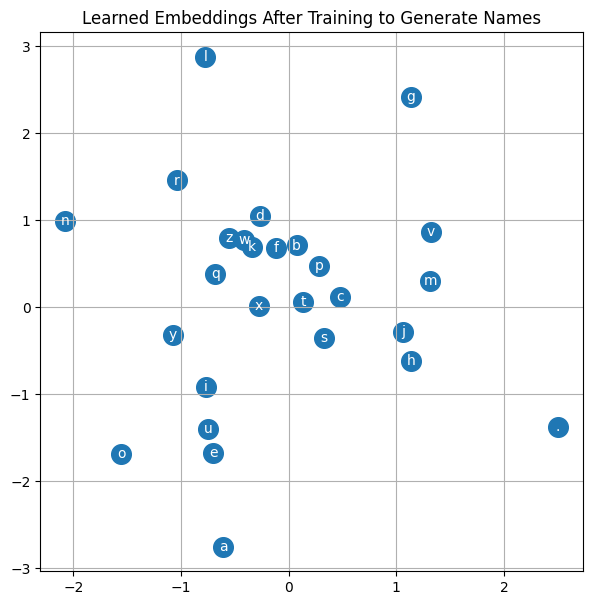

In [45]:
plt.figure(figsize=(7,7))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), ind_to_string[i], ha="center", va="center", color="white")
plt.grid('minor')
plt.title("Learned Embeddings After Training to Generate Names")
plt.show()

## Generate new Names

In [118]:
g = torch.Generator().manual_seed(111)
context_len = 3
for _ in range(10):
  context_block = [0] * context_len
  name = []
  while True:
    context_emb = C[torch.tensor([context_block])]
    hpreact = (context_emb.view(1,6) @ w1) + b1
    hpreact = bngain * ((hpreact - bmean)/bstd) + bnbias
    h = torch.tanh(hpreact) # Calculate hidden layer values
    logits = h @ w2 + b2
    probs = torch.softmax(logits,dim=1)
    ix = torch.multinomial(probs,num_samples=1, generator=g).item()
    # print(ind_to_string[ix],end='')
    name.append(ind_to_string[ix])
    if ix == 0:
      break
    context_block = context_block[1:] + [ix]
  print(''.join(name))

gurdynne.
sanap.
hosna.
tannanilini.
ypayhini.
muzu.
hhras.
hnan.
ficnasyamerelloi.
azzre.


**Sounds much better name like now !!!**

# Words Generation using the next charachter prediction

In [119]:
# don't show installation comments
! pip install -q datasets
! pip install -q contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.7 MB/s eta 0:00:00


In [120]:
from datasets import load_dataset
import nltk
import regex as re
from contractions import contractions_dict
import torch
import numpy as np
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader


# dataset = load_dataset("ccdv/cnn_dailymail", '3.0.0', trust_remote_code=True)
# cnn_dataset = load_dataset("cnn_dailymail", "3.0.0" , quiet=True)
cnn_dataset = load_dataset("cnn_dailymail", "3.0.0")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [121]:
# Methods for Data Cleaning
def get_data_corpus(data, n):
  """ Gets a string of n articles from the dataset
      Input - dataset, number of articles
      Output - string of n articles
  """
  corp = ''
  for i in range(n):
    corp = corp + ' '+ data['train'][i]['article']
  return corp

# Get expanded contractions
def expand_contractions(text, contraction_map=contractions_dict):
  """ Gets the expanded contractions
      Input - text: string, contraction_map: with all English contraction-expansion map
      Output - string of n articles with expanded contractions
  """
  con_key = '|'.join(contraction_map.keys())
  cppp = re.compile(f'({con_key})', flags=re.DOTALL)

  def e_m(contraction):
      match = contraction.group(0)
      exp_c = contraction_map.get(match)
      if not expand_contractions:
          print(match)
          return match
      return exp_c

  text_e = cppp.sub(e_m, text)
  text_e = re.sub("'", "", text_e)
  return text_e

def get_clean_data(input_t):
  """ Data Cleaning function
      Input - string of n articles
      Output - Cleaned string of n articles
  """

  input_text = expand_contractions(input_t)
  column_string = input_text #' '.join(dd['article'][0:250].tolist()) # Get rows to one big string

  column_string = expand_contractions(column_string)  # Expand contractions
  column_string = re.sub(r'-', ' ', column_string) # Replace hyphens with space

  column_string = re.sub("[^A-Za-z .]", "" , column_string) #re.sub("[^-9A-Za-z .]", "" , column_string) # Remove punctuations - in case we need to include more punctuations -> re.sub("[^a-zA-Z :\.]", "", line)
  # column_string = re.sub(r' ', '_', column_string) # Replace hyphens with space
  column_string = column_string.lower() # Convert to lowercase
  column_string = re.sub(r'\.', " ", column_string) # Replace dot with space and dot
  # column_string = re.sub(r'\.', "<EOS>", column_string) # Replace dot with <EOS> token
  column_string = re.sub("\s+"," ",column_string) # Remove extra spaces
  return column_string

## Get data from 'cnn_dailymail' dataset

In [348]:
n=10 # Number of articles to be considered from the dataset
articles_str = get_data_corpus(cnn_dataset, n)
articles_clean = get_clean_data(articles_str)
words = articles_clean.split()
# words = list(set(articles_clean.split()))
print(f"Total words in the first {n} articles : {len(words)}")

Total words in the first 10 articles : 6071


## Following same approach to prep data and split in train, val and test

In [349]:
# First let's check Unique characters in the data
chars = sorted(list(set(''.join(words))))
print("Unique Charachters:", chars)
print("Number of unique Chars:", len(chars))

# Note: 'chars' is sorted list of unique characters and index starts from 1....26
string_to_ind = {s:i+1 for i,s in enumerate(chars)} # +1 is to offset so that a starts with index 1

# We can introduce tokens <'S'> and <'E'>. But since we will have <'S'> as the first char(rows) and <'E'> as second (columns)
# it would be convinient to replace them with '.', depicting start and end when represented in row or col respectively
string_to_ind['.'] = 0

ind_to_string = {i:s for s,i in string_to_ind.items()}

Unique Charachters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Number of unique Chars: 26


In [350]:
# Create the final data
context_len = 3
X_list = []
Y_list = []

for w in words:
  context_block = [0] * context_len
  for ch in w + '.':
    X_list.append(context_block)
    Y_list.append(string_to_ind[ch])
    context_block = context_block[1:] + [string_to_ind[ch]]
X = torch.tensor(X_list)
Y = torch.tensor(Y_list)

In [351]:
X.shape, Y.shape

(torch.Size([33372, 3]), torch.Size([33372]))

In [352]:
# Shuffle X
idx = torch.randperm(X.shape[0])
X = X[idx]
Y = Y[idx]

n1 = int(len(X)*0.8) # 80% Training
n2 = int(len(X)*0.9) # 10% Validation and 10% Test data

X_train, Y_train = X[0:n1], Y[0:n1]
X_val, Y_val = X[n1:n2], Y[n1:n2]
X_test, Y_test = X[n2:], Y[n2:]

print("Train data:", X_train.shape, Y_train.shape, "      | ", round(X_train.shape[0]/X.shape[0],2)*100, "% of X")
print("Validation data:", X_val.shape, Y_val.shape, "   | ", round(X_val.shape[0]/X.shape[0],2)*100, "% of X")
print("Test data:", X_test.shape, Y_test.shape, "         | ", round(X_test.shape[0]/X.shape[0],2)*100, "% of X")

Train data: torch.Size([26697, 3]) torch.Size([26697])       |  80.0 % of X
Validation data: torch.Size([3337, 3]) torch.Size([3337])    |  10.0 % of X
Test data: torch.Size([3338, 3]) torch.Size([3338])          |  10.0 % of X


## Training - For word generation task

In [353]:
# Initiate all relevant parameters
context_len = 3
emb_dim = 2
n_hidden = 100
# batch_size = 10000

vocab_len = len(string_to_ind)
data_vector_len = context_len * emb_dim
g = torch.Generator().manual_seed(2147483647) # For reproducibility

# Embedding initialization -  A parameter
C = torch.randn((vocab_len,emb_dim), generator=g)

# Initialize the first layer (the only layer)
w1 = torch.nn.init.kaiming_normal_(torch.randn((data_vector_len,n_hidden), generator = g),nonlinearity='tanh',mode='fan_out')

b1 = torch.randn(n_hidden, generator=g) *0.001

# Initialize the Output layer
w2 = torch.randn((n_hidden,vocab_len), generator=g)*0.01   # Makes a big difference- This is to keep the Initialized weights closer to 0.
b2 = torch.randn(vocab_len, generator=g) *0      # Makes a big difference

# bngain and bnbias is the learning parameters in Batch normalization.
# This is to prevent the data to be exact normal.
#bngain ensure data scales up appropriately and bnbias shifts data from standard mean to represent the distribution effectively
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))

# The learnable parameters in this Architecture
# Technically bias can be removed here as we have batch norms taking care of it
parameters = [C,w1,b1,w2,b2,bngain,bnbias]
for p in parameters:
  p.requires_grad = True # Make sure the 'requires_grad' is True, which will help us calculate the gradients in the loss.backward() step

print("Number of parameters learned in this Network:",sum(p.nelement() for p in parameters))

Number of parameters learned in this Network: 3681


In [354]:
# Mini Batch update
batch_size = 1000
mini_batch_ind = get_batch_indices(X_train, batch_size)
train_loss_global = []
val_loss_global = []
num_epochs = 3000

for epoch in range(num_epochs):
  loss_track_local = []
  # # To speed up training only a random subset is used
  # torch.manual_seed(42)
  # idx = torch.randint(0,X_train.shape[0],(batch_size,))
  for idx in mini_batch_ind:
    # Forward pass
    embedded_X = C[X_train[idx]].view(X_train[idx].shape[0],data_vector_len) # Get the corresponding embeddings for the X data
    hpreact = (embedded_X @ w1) + b1 # Calculate hidden layer values

    # Adding the Batch Normalization
    #--------------------------------------------
    bmeani = hpreact.mean(dim=0,keepdim=True)
    bstdi = hpreact.std(dim=0,keepdim=True)
    hpreact = bngain * ((hpreact - bmeani)/bstdi) + bnbias
    #--------------------------------------------

    h = torch.tanh(hpreact)
    logits = h @ w2 + b2 # op layer logits
    #The above loss computation can be replicated with the below efficient code -- this is better for forward pass, backward pass --> efficient numerical computations
    loss = F.cross_entropy(logits, Y_train[idx])
    # if epoch % 100 == 0:
    #   print(loss.item())
    # print(loss.item())

    # Backward pass
    for p in parameters:
      p.grad = None
    loss.backward()
      # Get stats
    loss_track_local.append(loss.item())

    #update
    # if epoch < 500:
    #   lr = 0.1
    # # elif epoch < 500:
    # #   lr = 0.01
    # else:
    #   lr = 0.01
    lr = 0.1
    for p in parameters:
      p.data += -lr * p.grad
  avg_loss = sum(loss_track_local)/len(mini_batch_ind)
  train_loss_global.append(avg_loss)
  if epoch % 600 == 0 or epoch == num_epochs-1:
    # print(f"Average loss after {epoch} is: {sum(loss_track_local)/len(mini_batch_ind) :.2f}")
    print(f"Train loss after {epoch} epoch: {avg_loss :.2f}")  #loss wo mini batch

    # This step is needed to run validation to get the overall bmean and bstd
    with torch.no_grad():
      emb = C[X_train]
      hpreact = (emb.view(emb.shape[0],data_vector_len) @ w1) + b1
      bmean = hpreact.mean(dim = 0, keepdim = True)
      bstd = hpreact.std(dim = 0, keepdim = True)
    emb = C[X_val]
    hpreact = (emb.view(emb.shape[0],data_vector_len) @ w1) + b1
    # Adding the Batch Normalization
    hpreact = bngain * ((hpreact - bmean)/bstd) + bnbias
    h = torch.tanh(hpreact) # Calculate hidden layer values
    logits = h @ w2 + b2 # op layer logits
    #The above loss computation can be replicated with the below efficient code -- this is better for forward pass, backward pass --> efficient numerical computations
    loss = F.cross_entropy(logits, Y_val)
    print(f"Validation loss after {epoch} epoch: {loss.item():.4f}")

Train loss after 0 epoch: 3.09
Validation loss after 0 epoch: 2.9984
Train loss after 600 epoch: 2.01
Validation loss after 600 epoch: 2.0987
Train loss after 1200 epoch: 1.90
Validation loss after 1200 epoch: 2.0336
Train loss after 1800 epoch: 1.86
Validation loss after 1800 epoch: 2.0044
Train loss after 2400 epoch: 1.83
Validation loss after 2400 epoch: 1.9883
Train loss after 2999 epoch: 1.81
Validation loss after 2999 epoch: 1.9787


In [355]:
with torch.no_grad():
  emb = C[X_train]
  hpreact = (emb.view(emb.shape[0],data_vector_len) @ w1) + b1
  bmean = hpreact.mean(dim = 0, keepdim = True)
  bstd = hpreact.std(dim = 0, keepdim = True)

In [356]:
emb = C[X_val]
hpreact = (emb.view(emb.shape[0],data_vector_len) @ w1) + b1
# Adding the Batch Normalization
hpreact = bngain * ((hpreact - bmean)/bstd) + bnbias
h = torch.tanh(hpreact) # Calculate hidden layer values
logits = h @ w2 + b2 # op layer logits
#The above loss computation can be replicated with the below efficient code -- this is better for forward pass, backward pass --> efficient numerical computations
loss = F.cross_entropy(logits, Y_val)
print(f"Final Validation loss: {loss.item():.4f}")

Final Validation loss: 1.9787


In [357]:
emb = C[X_test]
hpreact = (emb.view(emb.shape[0],data_vector_len) @ w1) + b1
# Adding the Batch Normalization
hpreact = bngain * ((hpreact - bmean)/bstd) + bnbias
h = torch.tanh(hpreact) # Calculate hidden layer values
logits = h @ w2 + b2 # op layer logits
#The above loss computation can be replicated with the below efficient code -- this is better for forward pass, backward pass --> efficient numerical computations
loss = F.cross_entropy(logits, Y_test)
print(f"Final Test loss: {loss.item():.4f}")

Final Test loss: 1.9602


## Visualize Embeddings After Learning Word  generation

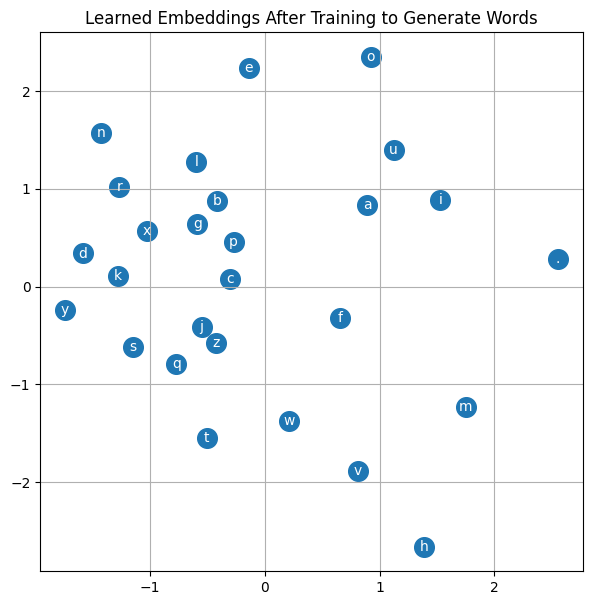

In [377]:
plt.figure(figsize=(7,7))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), ind_to_string[i], ha="center", va="center", color="white")
plt.grid('minor')
plt.title("Learned Embeddings After Training to Generate Words")
plt.show()

## Generate words

In [359]:
words_starting_from = 'a'
[string_to_ind[words_starting_from]] * 3

[1, 1, 1]

In [376]:
g = torch.Generator().manual_seed(77)
# words_starting_from = 'n'
context_len = 3

for _ in range(10):
  begins_with_ind = torch.randint(0,26,(1,),generator = g).item()
  context_block = [0,0,begins_with_ind] #string_to_ind[words_starting_from]
  name = []
  while True:
    context_emb = C[torch.tensor([context_block])]
    hpreact = (context_emb.view(1,6) @ w1) + b1
    hpreact = bngain * ((hpreact - bmean)/bstd) + bnbias
    h = torch.tanh(hpreact) # Calculate hidden layer values
    logits = h @ w2 + b2
    probs = torch.softmax(logits,dim=1)
    ix = torch.multinomial(probs,num_samples=1, generator=g).item()
    # print(ind_to_string[ix],end='')
    name.append(ind_to_string[ix])
    if ix == 0:
      break
    context_block = context_block[1:] + [ix]
  # print(words_starting_from + ''.join(name))
  print(ind_to_string[begins_with_ind] + ''.join(name))

says.
know.
ko.
guca.
lfried.
of.
meaassors.
at.
viclsi.
eat.


# Summary - So far

> **This Neural Network based architecture is way more flexible than the traditional N-gram approaches.**

> **This model does a better job than the Bigram model in both the tasks.**

> **The proposed framework can be extended in terms #layers, #neurons, #dimensions in embedding, Context length etc**

> **The next word (token) prediction can be implemented easily if we tokenize the text and feed in the 3 tokens to predict the next. The idea of learning the embeddings is a powerful one**

> **This leads us to explore more on the word embedding for us to build sophisticated Language models**